In [1]:
import matplotlib.pyplot as plt
import cv2
import torch
import timm
import numpy as np
from einops import reduce, rearrange, repeat


In [2]:
midas = torch.hub.load('D:/source/MiDaS', 'DPT_Hybrid', source='local')
midas.to('cuda')
midas.eval()

transforms = torch.hub.load('D:/source/MiDaS', 'transforms', source='local')
transform = transforms.dpt_transform

In [30]:
image_path = "D:/Downloads/dcim/image15.jpg"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Pad to times of kernel_size
h, w, _ = img.shape
kernel_size = w // 10
h32 = (h + kernel_size - 1) // kernel_size * kernel_size
w32 = (w + kernel_size - 1) // kernel_size * kernel_size
img = cv2.resize(img, (w32, h32))

In [31]:
def max_pool(x, kernel_size=32):
  return reduce(x, '(h k1) (w k2) -> h w', 'max', k1=kernel_size, k2=kernel_size)


def avg_pool(x, kernel_size=32):
  return reduce(x, '(h k1) (w k2) -> h w', 'mean', k1=kernel_size, k2=kernel_size)


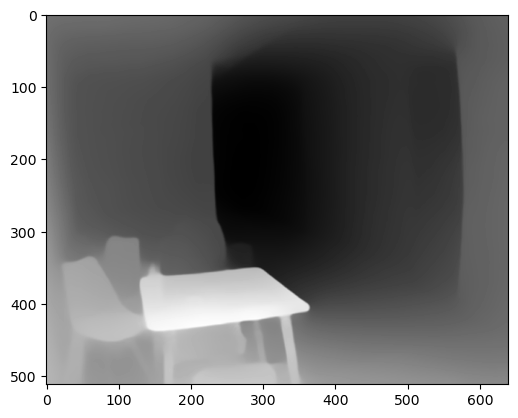

In [32]:
input_batch = transform(img).to('cuda')
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

out = prediction.cpu().numpy()
a = out.max()

out = (out / a)*255
out = (out).astype(np.uint8)

plt.imshow(out, cmap='gray')


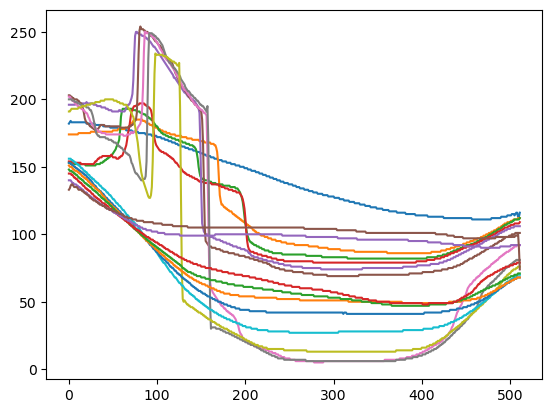

In [46]:
x = np.linspace(0, w - 1, 16, dtype=np.int64)
sample_lines = rearrange(out[::-1, x], 'h c -> c h').astype(np.float32)
for i in range(16):
    plt.plot(sample_lines[i])
plt.show()

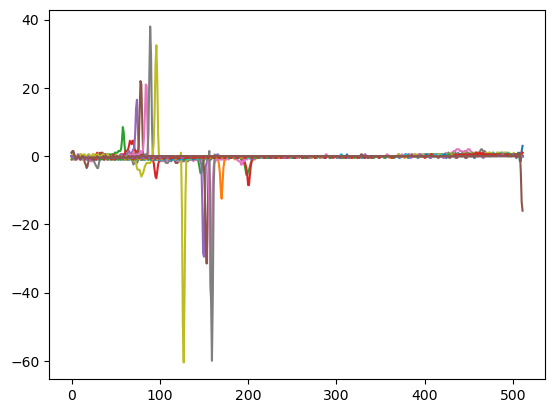

In [47]:
sample_grad = np.zeros_like(sample_lines)
for i in range(16):
    sample_grad[i] = np.gradient(sample_lines[i])
    plt.plot(sample_grad[i])
plt.show()

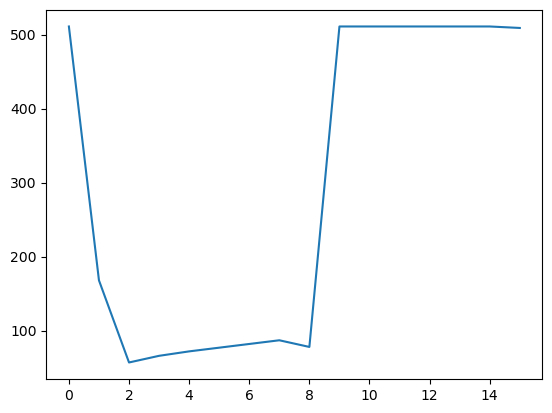

In [44]:
dist = np.argmax(np.abs(sample_grad) > 4, axis=1)
dist[dist == 0] = h32 - 1
plt.plot(dist)

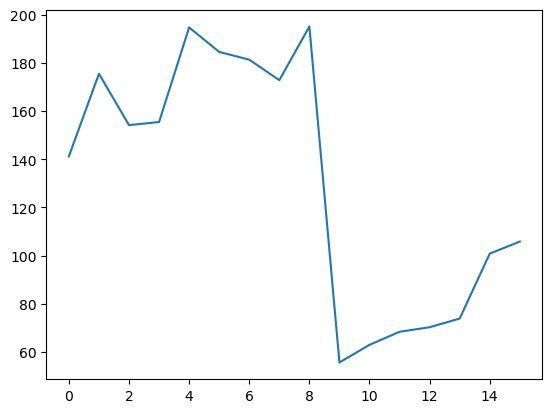

In [57]:
col = np.zeros_like(dist, dtype=np.float32)
for i in range(16):
    col[i] = np.mean(sample_lines[i, :dist[i]])
plt.plot(col)

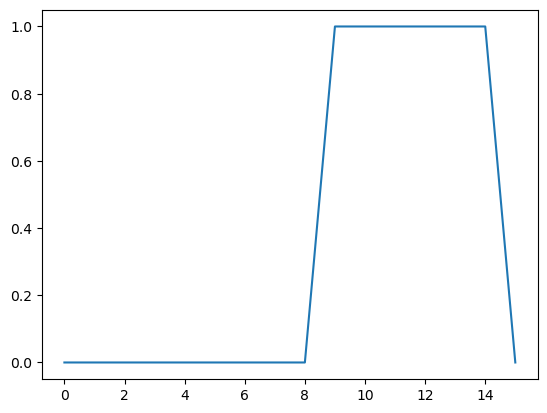

In [58]:
walkable = (col< np.min(col) + 50) * (dist.astype(np.float32) > h * 0.15)
plt.plot(walkable)

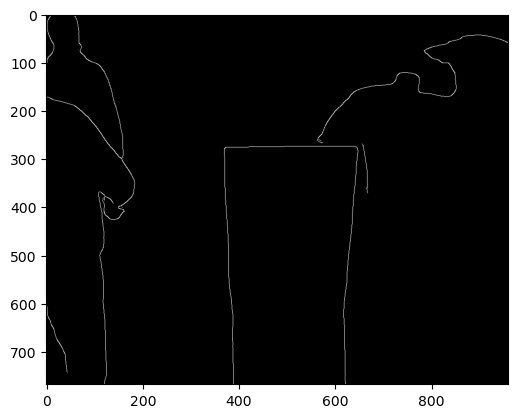

In [14]:
canny = cv2.Canny(out, 50, 10)
plt.imshow(canny, cmap='gray')

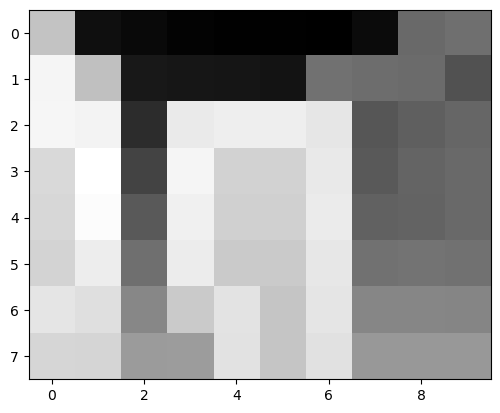

In [7]:
score = max_pool(canny, kernel_size) / 8 + max_pool(out, kernel_size)
plt.imshow(score, cmap='gray')

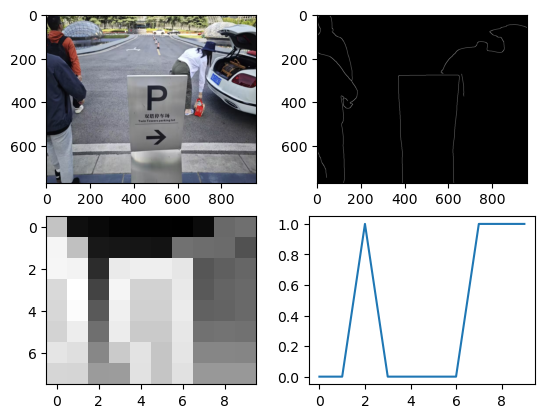

In [8]:
grad1score = score[-1] - score[-2]
grad2score = np.abs(score[-1] + score[-3] - score[-2] * 2)
disscore = score[-2].copy()
disscore[grad1score < 20] = 1000
disscore[grad2score > 20] = 1000
walkable = (disscore < np.min(disscore) + 30) * (disscore < 1000)

# Subplot: img | out | score | score1d
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(img, cmap='gray')
axs[0, 1].imshow(canny, cmap='gray')
axs[1, 0].imshow(score, cmap='gray')
axs[1, 1].plot(walkable)
plt.show()